##Consider the paper: <https://arxiv.org/abs/1804.03209>

The Speech Commands dataset contains 35 spoken words from 2,618 people, with each recording lasting one second in WAV format. It's designed for training and evaluating keyword spotting models. The paper highlights metrics like top-one error rate for performance evaluation, making it valuable for comparing and developing voice-trigger models.

In [ ]:
import os

import numpy as np
from tensorflow_datasets.core import lazy_imports_lib
import tensorflow_datasets.public_api as tfds

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install pydub


## Step 1: Load the Speech Commands dataset using tensorflow_datasets (TFDS)

In [ ]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True)

#Split the dataset into training and testing sets
train_dataset = dataset['train']
test_dataset = dataset['test']

##Statistically analysis

In [ ]:
#Number of Classes and Class Distribution
labels = []
for _, label in train_dataset:
    labels.append(int(label.numpy()))

unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

Class distribution: {0: 3134, 1: 3106, 2: 3037, 3: 3130, 4: 2970, 5: 3086, 6: 3019, 7: 3111, 8: 2948, 9: 3228, 10: 668, 11: 54074}


In [ ]:
#Duration and Sample Rate of Audio Samples

durations = []
sample_rates = []

def audio_properties(audio, label):
    # Convert the audio tensor to a NumPy array
    audio_np = audio.numpy()  # Convert Tensor to NumPy
    duration = len(audio_np) / 16000  # Assuming the sample rate is 16kHz for all clips
    durations.append(duration)
    sample_rates.append(16000)  # 16kHz is the fixed rate in the dataset
    return audio, label

# Map the function to extract durations
train_dataset = train_dataset.map(lambda audio, label: tf.py_function(audio_properties, [audio, label], [audio.dtype, label.dtype]))

# Iterate through the dataset to populate the durations list
for audio, label in train_dataset:
    pass  # This will trigger the mapping and call the audio_properties function

# Step 4: Calculate the Average Duration and Stats if durations is not empty
if durations:
    mean_duration = np.mean(durations)
    std_duration = np.std(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    print(f"Average duration: {mean_duration:.2f} seconds")
    print(f"Standard deviation of duration: {std_duration:.2f} seconds")
    print(f"Min duration: {min_duration:.2f} seconds")
    print(f"Max duration: {max_duration:.2f} seconds")
else:
    print("No durations calculated. Please check the dataset.")


Average duration: 0.98 seconds
Standard deviation of duration: 0.07 seconds
Min duration: 0.26 seconds
Max duration: 1.00 seconds


Class distribution: {0: 3134, 1: 3106, 2: 3037, 3: 3130, 4: 2970, 5: 3086, 6: 3019, 7: 3111, 8: 2948, 9: 3228, 10: 668, 11: 54074}


<ipython-input-21-be52ab370b4e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')


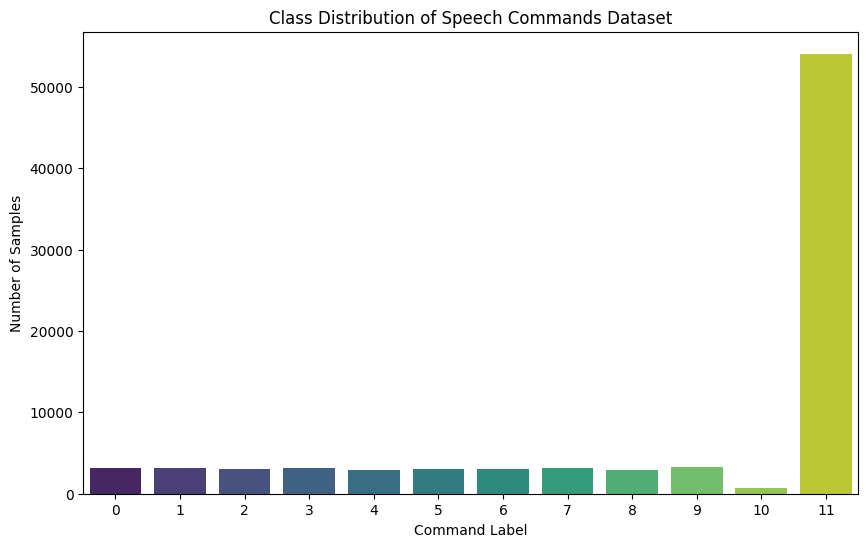

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

# Visualize Class Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title("Class Distribution of Speech Commands Dataset")
plt.xlabel("Command Label")
plt.ylabel("Number of Samples")
plt.show()

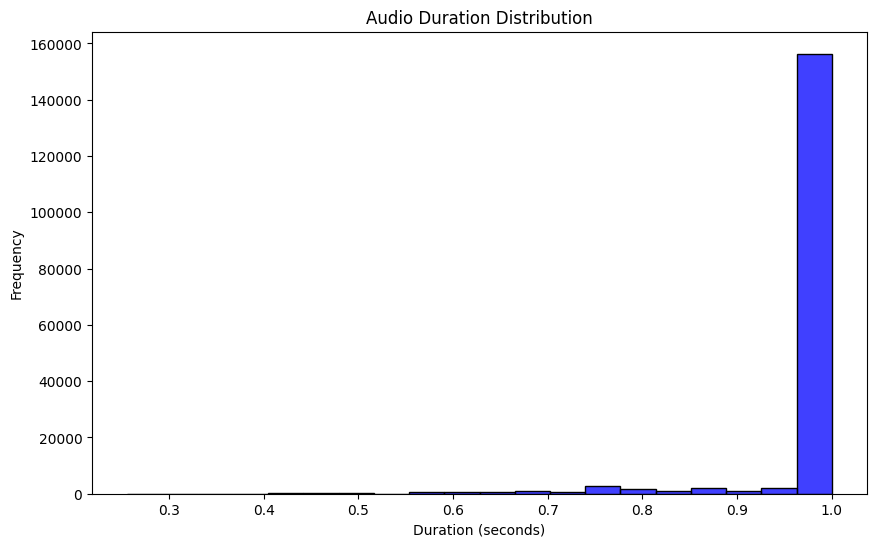

In [ ]:
# Visualize Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(durations, bins=20, color='blue')
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

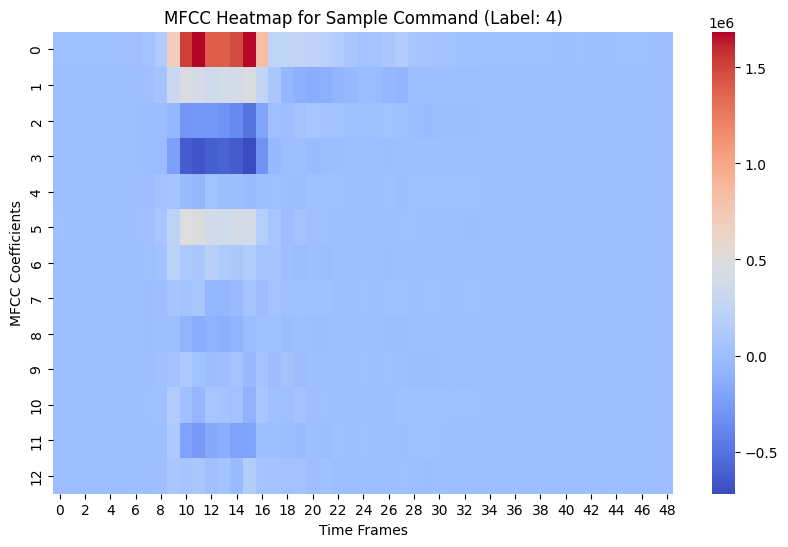

In [ ]:
#Audio Feature Extraction - MFCC Analysis
def extract_mfcc(audio, label):
    # Convert the audio tensor to a floating-point type
    audio = tf.cast(audio, tf.float32)

    # Compute MFCCs from log-mel spectrograms
    stft = tf.signal.stft(audio, frame_length=640, frame_step=320, fft_length=512)
    spectrogram = tf.abs(stft)

    # Compute log-mel spectrogram
    log_mel_spectrogram = tf.tensordot(spectrogram, tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=40, num_spectrogram_bins=257, sample_rate=16000), axes=1)

    # Compute MFCCs and take the first 13 coefficients
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :13]
    return mfccs, label

# Map MFCC extraction
train_dataset_mfcc = train_dataset.map(extract_mfcc)

# Visualize MFCC Heatmap for a Sample
for mfcc, label in train_dataset_mfcc.take(1):
    mfcc_np = mfcc.numpy()
    plt.figure(figsize=(10, 6))
    sns.heatmap(mfcc_np.T, cmap='coolwarm', cbar=True)
    plt.title(f"MFCC Heatmap for Sample Command (Label: {label.numpy()})")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.show()